
# Install and import libraries

In [ ]:
pip install diffrax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.7/141.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 11.2 MB/s eta 0:00:00


In [ ]:
pip install h5py typing-extensions wheel

In [ ]:
pip install scipy cvxpy bagpy pyquaternion jaxopt transforms3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.6 MB/s eta 0:00:00


In [ ]:
# !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate

# import equinox.experimental as eqxe
import jax.tree_util as jtu
import functools as ft

import cvxpy as cp

import plotly.graph_objects as go

import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from numpy import savetxt

# Read and plot the demo from .npy file

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
# save numpy array as csv file
from numpy import savetxt

data_dir_all  = ["/content/drive/MyDrive/Colab Notebooks/Quaternion_DS_Continual_learning/pouring.npy",
                 "/content/drive/MyDrive/Colab Notebooks/Quaternion_DS_Continual_learning/platestandingtolying.npy",
                 "/content/drive/MyDrive/Colab Notebooks/Quaternion_DS_Continual_learning/openbox.npy",
                 "/content/drive/MyDrive/Colab Notebooks/Quaternion_DS_Continual_learning/bottle2shelf.npy"
                ]

traj_data_load_all = []
for data_dir in data_dir_all:
  with open(data_dir, 'rb') as f:
    traj_data_load_all.append(np.load(f))


fig = go.Figure()
ind_task = 0 # which task
traj_data_process = jnp.copy(traj_data_load_all[ind_task])
n_D = traj_data_load_all[ind_task].shape[0]
for i in range(n_D):
  fig.add_trace(go.Scatter3d(x=traj_data_process[i, :, 0], y=traj_data_process[i, :, 1], z=traj_data_process[i, :, 2], mode='lines',
                            line=dict(color='gray', width=4)))
  fig.add_trace(go.Scatter3d(x=traj_data_process[i, :1, 0], y=traj_data_process[i, :1, 1], z=traj_data_process[i, :1, 2], mode='markers',
                            line=dict(color='red', width=1)))
  fig.add_trace(go.Scatter3d(x=traj_data_process[i, -2:-1, 0], y=traj_data_process[i, -2:-1, 1], z=traj_data_process[i, -2:-1, 2], mode='markers',
                            line=dict(color='blue', width=1)))
fig.show()

ind = 0
nsamples = traj_data_load_all[ind].shape[1]
ts_new = np.linspace(0, 1, nsamples)

# Normalize position dimensions in the trajectory data to [0, 1]

In [ ]:
from sklearn import preprocessing

traj_xyz = []
minmax = []
# dim = traj_data_process.shape[-1]
dim = 3
for i in range(dim):
  min = jnp.min(traj_data_process[:, :, i])
  max = jnp.max(traj_data_process[:, :, i])
  traj_xyz.append((traj_data_process[:, :, i] - min)/(max - min))
  minmax.append(jnp.array([min, max]))

traj_standard = jnp.copy(traj_data_process)
for i in range(dim):
  traj_standard = traj_standard.at[:, :, i].set(traj_xyz[i])

# traj_standard = jnp.copy(traj_data_process)

In [ ]:
# Position trajectory
fig = go.Figure()
for i in range(traj_data_process.shape[0]):
  fig.add_trace(go.Scatter3d(x=traj_standard[i, :, 0], y=traj_standard[i, :, 1], z=traj_standard[i, :, 2], mode='lines',
                            line=dict(color='gray', width=4)))
  fig.add_trace(go.Scatter3d(x=traj_standard[i, :1, 0], y=traj_standard[i, :1, 1], z=traj_standard[i, :1, 2], mode='markers',
                            line=dict(color='red', width=1)))
  fig.add_trace(go.Scatter3d(x=traj_standard[i, -2:-1, 0], y=traj_standard[i, -2:-1, 1], z=traj_standard[i, -2:-1, 2], mode='markers',
                            line=dict(color='blue', width=1)))
fig.show()

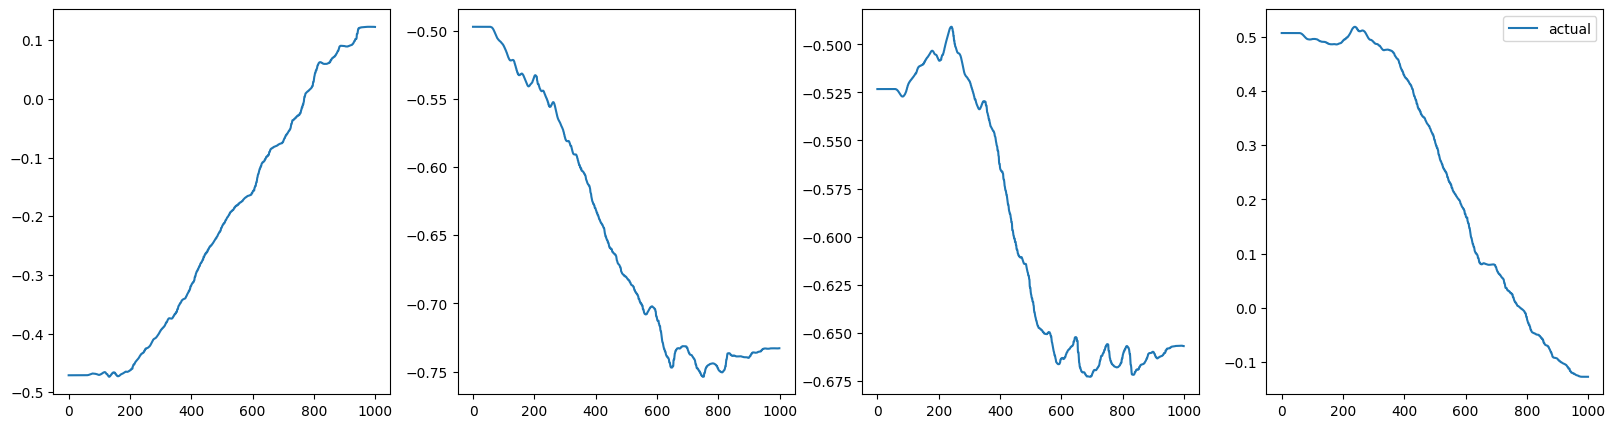

In [ ]:
# Quaternion trajectory
ind_demo = 0
fig, axs = plt.subplots(1,4, figsize=(20,5))
for i in range(4):
  axs[i].plot(traj_standard[ind_demo, :, 3+i], label='actual')
plt.legend()

# Define the model

In [ ]:
class Func_rot(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        initializer = jnn.initializers.orthogonal()
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size - 1, # -1 because we only need angular velocity
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )
        model_key = key
        key_weights = jrandom.split(model_key, depth+1)

        for i in range(depth+1):
          where = lambda m: m.layers[i].weight
          shape = self.mlp.layers[i].weight.shape
          self.mlp = eqx.tree_at(where, self.mlp, replace=initializer(key_weights[i], shape, dtype = jnp.float32))

    @eqx.filter_jit
    def quat_mult(self, q1, q2):
      q1_s = q1[0]
      q2_s = q2[0]
      q1_v = q1[1:].reshape((-1,1))
      q2_v = q2[1:].reshape((-1,1))
      scalar = q1_s*q2_s - q1_v.T @ q2_v
      skew = jnp.array([[0, -q1[3], q1[2]],
                        [q1[3], 0, -q1[1]],
                        [-q1[2], q1[1], 0]])
      vector = q1_s*q2_v + q2_s*q1_v + skew @ q2_v
      q_result = jnp.concatenate((scalar, vector), axis=0).flatten()
      return q_result

    @eqx.filter_jit
    def __call__(self, t, y, args):

        raw_vect_field = self.mlp(y)

        ang_vel = raw_vect_field[3:]

        quat = y[3:]

        ang_vel_quat = jnp.concatenate((jnp.array([0]), ang_vel))

        quat_vect_field = 0.5*self.quat_mult(ang_vel_quat, quat)

        result_vect_field = jnp.concatenate((raw_vect_field[:3], quat_vect_field))

        return result_vect_field

Here we wrap up the entire ODE solve into a model.

In [ ]:
class NeuralODE_rot(eqx.Module):
    func_rot: Func_rot

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func_rot = Func_rot(data_size, width_size, depth, key=key)

    @eqx.filter_jit
    def __call__(self, ts, yd0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func_rot),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=yd0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )

        pose_traj = solution.ys

        position = pose_traj[:, :3]
        quat = pose_traj[:, 3:]
        quat_norm = jnp.linalg.norm(quat, axis=-1)
        quat_pred_norm = quat/jnp.expand_dims(quat_norm, axis=-1)
        # quat_pred_norm = quat
        pose_traj_result = jnp.concatenate((position, quat_pred_norm), axis=-1)

        return pose_traj

# Data loader

In [ ]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

# Train

In [ ]:
def main(
    dataset_size=6,
    batch_size=3,
    lr_strategy=(3e-3, 3e-3, 3e-3, 3e-4, 3e-4),
    steps_strategy=(5000, 5000, 7000, 7000, 7000),
    length_strategy=(0.3, 0.5, 0.7, 0.9, 1),
    width_size=64,
    depth=3,
    seed=1000,
    plot=True,
    print_every=100,
    save_every = 1000,
):
    key = jrandom.PRNGKey(seed)
    data_key, model_key, loader_key = jrandom.split(key, 3)
    file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/clfd_bottle2shelf.eqx"

    # with quaternion data

    ys = traj_standard[:dataset_size]
    ts = ts_new

    _, length_size, data_size = ys.shape

    model = NeuralODE_rot(data_size, width_size, depth, key=model_key)
    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    @eqx.filter_value_and_grad
    @eqx.filter_jit
    def grad_loss(model, ti, yi):
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
        loss = jnp.mean((yi - y_pred) ** 2)
        return loss

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        decay_scheduler = optax.cosine_decay_schedule(lr, decay_steps=steps, alpha=0.9)
        # decay_scheduler = optax.piecewise_constant_schedule(init_value=lr, boundaries_and_scales={int(steps*0.25):0.5, int(steps*0.5):0.5, int(steps*0.75):0.5})
        # decay_scheduler = optax.exponential_decay(init_value=lr, transition_steps=steps, decay_rate=0.9, transition_begin=int(steps*0.25), staircase=False)
        # decay_scheduler = optax.linear_schedule(init_value=lr, end_value=0.005*lr, transition_steps=steps, transition_begin=int(steps*0.25))
        optim = optax.adabelief(learning_rate=decay_scheduler)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        # _ys_dot = []
        ## No batches
        # for step in range(steps):
        #   start = time.time()
        #   loss, model, opt_state = make_step(_ts, _ys, model, opt_state)
        #   end = time.time()
        #   if (step % print_every) == 0 or step == steps - 1:
        #     print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")
        #   if (step % save_every) == 0 or step == steps-1:
        #     eqx.tree_serialise_leaves(file_name, model)
        ## Batches
        for step, (yi,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

    # if plot:
    #     plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
    #     plt.plot(ts, ys[0, :, 1], c="dodgerblue")
    #     model_y = model(ts, ys[0, 0])
    #     plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
    #     plt.plot(ts, model_y[:, 1], c="crimson")
    #     plt.legend()
    #     plt.tight_layout()
    #     plt.savefig("neural_ode.png")
    #     plt.show()

    return ts, ys, model

In [ ]:
ts, ys, model = main()

Step: 0, Loss: 0.02893662638962269, Computation time: 7.966804504394531
Step: 100, Loss: 0.001326431636698544, Computation time: 0.006050586700439453
Step: 200, Loss: 0.0011668233200907707, Computation time: 0.024880409240722656
Step: 300, Loss: 0.0013301201397553086, Computation time: 0.014938831329345703
Step: 400, Loss: 0.0006771290209144354, Computation time: 0.006216287612915039
Step: 500, Loss: 0.0009317793301306665, Computation time: 0.00635218620300293
Step: 600, Loss: 0.00044037005864083767, Computation time: 0.006796121597290039
Step: 700, Loss: 0.00037009306834079325, Computation time: 0.009077072143554688
Step: 800, Loss: 0.0003832889487966895, Computation time: 0.011835336685180664
Step: 900, Loss: 0.00038907071575522423, Computation time: 0.010695934295654297
Step: 1000, Loss: 0.0003833804512396455, Computation time: 0.011843442916870117
Step: 1100, Loss: 0.0002162652526749298, Computation time: 0.007613420486450195
Step: 1200, Loss: 0.0002262472698930651, Computation tim

# Save the model

In [ ]:
file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/clfd_bottle2shelf.eqx"
eqx.tree_serialise_leaves(file_name, model)

# Load the model

In [ ]:
# load the saved model
file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/clfd_data_models/ICRA/clfd_pouring_ICRA.eqx"
dataset_size = 1
ys = traj_standard[:dataset_size]
ts = ts_new
_, length_size, data_size = ys.shape
width_size=64
depth=3
seed=1000
key = jrandom.PRNGKey(seed)
data_key, model_key, loader_key = jrandom.split(key, 3)
model1 = NeuralODE_rot(data_size, width_size, depth, key=model_key)
model_load= eqx.tree_deserialise_leaves(file_name, model1)

In [ ]:
traj_standard.shape

(9, 1000, 7)

# Denormalize and Plot the predicted trajectories

In [ ]:
ys_pred_act_all = []
# denormalize
for ind in range(traj_data_process.shape[0]):
  ys_pred = model_load(ts, traj_standard[ind, 0])
  traj_xyz = []
  for i in range(dim):
    min = minmax[i][0]
    max = minmax[i][1]
    traj_xyz.append(ys_pred[:, i] * (max - min) + min)

  ys_pred_act = jnp.copy(ys_pred)

  for i in range(dim):
    ys_pred_act = ys_pred_act.at[:, i].set(traj_xyz[i])

  ys_pred_act_all.append(ys_pred_act)
ys_pred_act_all = jnp.array(ys_pred_act_all)

In [ ]:
# Position trajectory
ys_act = jnp.copy(traj_data_process)
fig = go.Figure()
ind_demo = 0 # which demonstration for the given task.
fig.add_trace(go.Scatter3d(x=ys_act[ind_demo, :, 0], y=ys_act[ind_demo, :, 1], z=ys_act[ind_demo, :, 2], mode='lines',
                          line=dict(color='gray', width=10), name='Demonstration'))

fig.add_trace(go.Scatter3d(x=ys_pred_act_all[ind_demo, :, 0], y=ys_pred_act_all[ind_demo, :, 1], z=ys_pred_act_all[ind_demo, :, 2], mode='lines',
                           line=dict(color='green', width=10), name='Predicted'))

fig.add_trace(go.Scatter3d(x=ys_act[ind_demo, :1, 0], y=ys_act[ind_demo, :1, 1], z=ys_act[ind_demo, :1, 2], mode='markers',
                          line=dict(color='red', width=5), name='Start'))
fig.add_trace(go.Scatter3d(x=ys_act[ind_demo, -2:-1, 0], y=ys_act[ind_demo, -2:-1, 1], z=ys_act[ind_demo, -2:-1, 2], mode='markers',
                          line=dict(color='blue', width=5), name='End'))
fig.update_layout(
    font=dict(
        family="Times New Roman",
        size=18
    ),
    legend= {'itemsizing': 'constant'},
    scene=dict(aspectmode="cube")
)

fig.show()

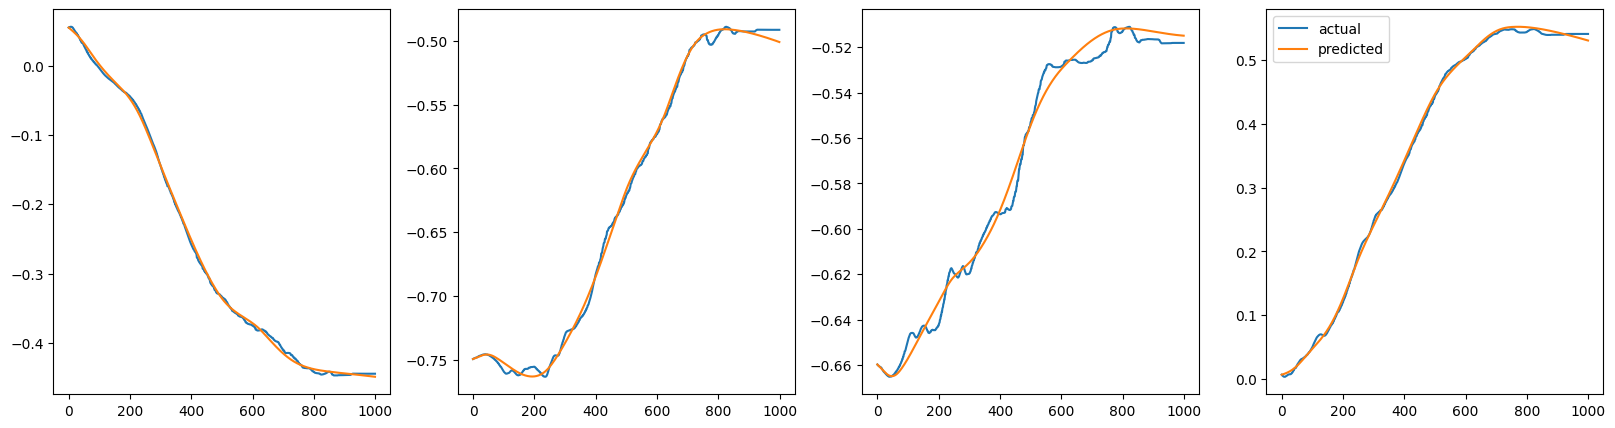

In [ ]:
# Quaternion trajectory
fig, axs = plt.subplots(1,4, figsize=(20,5))
for i in range(4):
  axs[i].plot(traj_data_process[ind_demo, :, 3+i], label='actual')
  axs[i].plot(ys_pred_act_all[ind_demo, :,3+i], label='predicted')
plt.legend()

# Using rotation matrices to plot quaternion trajectories

In [ ]:
import plotly.graph_objects as go
import numpy as np
from transforms3d import quaternions

def quat_to_rot_mat(quaternions_data):
  num_quaternions = quaternions_data.shape[0]
  quaternions_data /= np.linalg.norm(quaternions_data, axis=1, keepdims=True)
  # Convert quaternions to rotation matrices
  rotation_matrices = np.array([quaternions.quat2mat(quaternions_data[i]) for i in range(quaternions_data.shape[0])])
  return rotation_matrices

ys_pred = ys_pred_act_all[ind_demo]

rotation_matrices_pred = quat_to_rot_mat(ys_pred[::5, 3:])
rotation_matrices_data = quat_to_rot_mat(ys_act[ind_demo, ::5, 3:])
num_quaternions = ys_pred.shape[0]

phi, theta = np.mgrid[0.0:2.0*np.pi:100j, 0.0:np.pi:50j]
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

# Plot on the SO(3) manifold
figs_rot = go.Figure()
# for i in range(3):
figs_rot.add_trace(go.Surface(x=x, y=y, z=z, colorscale='Blues', opacity=0.5, showlegend=False, showscale=False))

color_all = ['#AB63FA', '#FFA15A', '#FF6692']
color_all_pred = ['#2CA02C', '#D62728', '#8C564B']
name_all = ['Data 1', 'Data 2', 'Data 3']
name_all_pred = ['Predicted 1', 'Predicted 2', 'Predicted 3']

for i in range(3):
  figs_rot.add_trace(go.Scatter3d(x=rotation_matrices_data[:, 0, i], y=rotation_matrices_data[:, 1, i], z=rotation_matrices_data[:, 2, i],
                                     mode='lines', line=dict(width=10, color=color_all[i]), name=name_all[i]))
  figs_rot.add_trace(go.Scatter3d(x=rotation_matrices_pred[:, 0, i], y=rotation_matrices_pred[:, 1, i], z=rotation_matrices_pred[:, 2, i],
                                     mode='lines', line=dict(width=10, color=color_all_pred[i]), name=name_all_pred[i]))

for i in range(3):
  x_s, y_s, z_s = rotation_matrices_data[0, :, i].T
  x_e, y_e, z_e = rotation_matrices_data[-1, :, i].T
  if i == 2:
    figs_rot.add_trace(go.Scatter3d(x=[x_s], y=[y_s], z=[z_s], mode='markers', line=dict(color='red', width=5),  name='Start'))
    figs_rot.add_trace(go.Scatter3d(x=[x_e], y=[y_e], z=[z_e], mode='markers', line=dict(color='blue', width=5),  name='End'))
  else:
    figs_rot.add_trace(go.Scatter3d(x=[x_s], y=[y_s], z=[z_s], mode='markers', line=dict(color='red', width=5),  name='Start', showlegend=False))
    figs_rot.add_trace(go.Scatter3d(x=[x_e], y=[y_e], z=[z_e], mode='markers', line=dict(color='blue', width=5),  name='End', showlegend=False))

figs_rot.update_layout(
    font=dict(
        family="Times New Roman",
        size=18
    ),
    legend= {'itemsizing': 'constant'},
    scene=dict(aspectmode="cube")
)

figs_rot.show()

# Quaternion error

In [ ]:
def quat_mult(q1, q2):
  q1_s = q1[0]
  q2_s = q2[0]
  q1_v = q1[1:].reshape((-1,1))
  q2_v = q2[1:].reshape((-1,1))
  scalar = q1_s*q2_s - q1_v.T @ q2_v
  skew = jnp.array([[0, -q1[3], q1[2]],
                    [q1[3], 0, -q1[1]],
                    [-q1[2], q1[1], 0]])
  vector = q1_s*q2_v + q2_s*q1_v + skew @ q2_v
  q_result = jnp.concatenate((scalar, vector), axis=0).flatten()
  return q_result

def Log_map(q):
  q_s = q[0]
  vector = q[1:]
  vector_norm = jnp.linalg.norm(vector)

  # Round off scalar_quat_prod to take care of errors due to numerical errors
  q_s = jnp.round(q_s, 4)

  log_quat = jnp.where(vector_norm > 0, jnp.arccos(q_s)*(vector/vector_norm), jnp.array([0.0,0.0,0.0]))
  # log_quat = jnp.arccos(q_s)*(vector/vector_norm)

  return log_quat

def quat_err(q1, q2):
  q1 = q1/jnp.linalg.norm(q1)
  q2 = q2/jnp.linalg.norm(q2)
  q2_c = q2.at[1:].set(-q2[1:])
  delta_q = quat_mult(q1, q2_c)
  return Log_map(delta_q)

# CLF-QP for SO(3)

In [ ]:
from jaxopt import OSQP
from jax import jit

In [ ]:
f = lambda z : model_load.func_rot.mlp(z)
start =  traj_standard[ind_demo, 0]
xref = model_load(ts, start)
fxref = jax.vmap(f, in_axes = 0)(xref)
x = start
dist = np.array([-0.5, 0.0, 0.0, -0.3, 0.0, 0.5,  0.0])
dist_ind = 300
xall = jnp.expand_dims(x, axis=0)
alpha_V = 20
dti=jnp.mean(jnp.diff(ts))

N = 0

vopt_all = []

@jit
def target_track(x, closest_ind):

  x_t=jnp.copy(x).reshape((-1,1)) # dim x 1
  q = x_t[3:]

  dist_ref = jnp.linalg.norm(xref[:, :3] - x_t[:3].reshape((1,-1)), axis=1)
  closest_ind = jnp.argmin(dist_ref)

  chosen_ind = closest_ind + N

  is_ind_limit = chosen_ind < xref.shape[0]

  loop_ind = 0

  xref_ind = jnp.where(is_ind_limit, chosen_ind, loop_ind)

  # xref_ind = i

  xref_t = xref[xref_ind].reshape((-1,1)) # dim x 1

  # xref_t = xref_g

  qref = xref_t[3:]

  scale_q = 1

  scale_p = 1

  Q_opt = jnp.vstack((jnp.hstack((scale_p*jnp.eye(3), jnp.zeros((3,3)))), jnp.hstack((jnp.zeros((3,3)), scale_q*jnp.eye(3)))))
  print(Q_opt.shape)
  e = x_t - xref_t
  e = e.at[3:].set(e[3:]/jnp.linalg.norm(e[3:]))
  e_p = e[:3]
  e_q = e[3:]
  V = jnp.sum(jnp.square(2*e))/4

  g_x = f(x_t[:, 0]).reshape((-1,1))
  g_p_x = g_x[:3]

  w_g_x = g_x[3:].reshape((-1,1))
  g_w_x = jnp.vstack((0.0, w_g_x))

  g_xref = fxref[xref_ind].reshape((-1,1))
  g_p_xref = g_xref[:3]

  w_g_xref = g_xref[3:].reshape((-1,1))
  g_w_xref = jnp.vstack((0.0, w_g_xref))

  s_p = jnp.vdot(e_p, g_p_x - g_p_xref)
  s_q = jnp.vdot(e_q/2.0, quat_mult(g_w_x[:, 0], q[:, 0]).reshape((-1,1)) - quat_mult(g_w_xref[:, 0], qref[:, 0]).reshape((-1,1)))

  s = s_p + s_q

  Q = jnp.array([[q[0, 0], q[1, 0], q[2, 0], q[3, 0]],
                [-q[1, 0], q[0,0], q[3, 0], -q[2, 0]],
                [-q[2, 0], -q[3, 0], q[0, 0], q[1, 0]],
                [-q[3, 0], q[2, 0], -q[1, 0], q[0, 0]]])
  Q2 = Q[:, 1:] # 4 x 3
  Q2_minus = -Q2
  Q2_1 = jnp.vstack((Q2_minus[0, :], -Q2_minus[1:,:]))

  G_opt = 2*jnp.hstack((e_p.T, (e_q.T/2.0) @ Q2_1))
  h_opt = jnp.array([-alpha_V*V - 2*s])

  qp = OSQP()

  sol = qp.run(params_obj=(Q_opt,jnp.zeros(Q_opt.shape[0])), params_ineq=(G_opt, h_opt)).params

  ustar = sol.primal.reshape((-1,1))

  u_p_x = ustar[:3]
  u_w_x = jnp.vstack((0.0, ustar[3:]))

  p_dot = g_p_x + u_p_x
  q_dot = 0.5*quat_mult(g_w_x[:, 0] + u_w_x[:, 0], q).reshape((-1,1))

  x_dot_cmd = jnp.vstack((p_dot, q_dot))[:, 0]

  f_x_dot_cmd = lambda t, z, args : x_dot_cmd

  solution = diffrax.diffeqsolve(
      diffrax.ODETerm(f_x_dot_cmd),
      diffrax.Tsit5(),
      t0=0,
      t1=dti,
      dt0=dti,
      y0=x,
      stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
      saveat=diffrax.SaveAt(ts=jnp.array([0, dti])),
  )

  xnext = solution.ys[-1,:]

  xnext = xnext.at[3:].set(xnext[3:]/jnp.linalg.norm(xnext[3:]))

  return xnext

for i in range(int(2*(len(ts)))):

  # if(i==66):
  #   # indx = indx_angle
  #   # model_load = model_load_angle
  #   x = jnp.array([-0.4, -0.25])

  if(i==dist_ind):
    x = x + dist
    x = x.at[3:].set(x[3:]/jnp.linalg.norm(x[3:]))
    x_dist = jnp.copy(x).reshape((-1,1))
    x_dist_p = jnp.copy(xall[-1]).reshape((-1,1))

  xnext = target_track(x, i)

  xall = jnp.append(xall, jnp.expand_dims(xnext, axis=0), axis=0)

  x = xnext

  if(i%100==0):
    print(f"Time: {i}, Position: {x}")

(6, 6)
Time: 0, Position: [ 0.6152051   0.90651417  0.55200595 -0.47070134 -0.49750596 -0.5231205
  0.50722086]
Time: 100, Position: [ 0.6350281   0.882565    0.66407335 -0.46177414 -0.5157773  -0.5156001
  0.5048713 ]
Time: 200, Position: [ 0.7168648   0.7155208   0.92982334 -0.45747593 -0.53705984 -0.50869375
  0.49347073]
Time: 300, Position: [ 0.17424858  0.45163792  0.8136361  -0.6685306  -0.5800026  -0.0386617
  0.46386316]
Time: 400, Position: [ 0.3711053   0.12067398  0.4708589  -0.2365797  -0.6789555  -0.6148542
  0.32404298]
Time: 500, Position: [ 0.2841617   0.04769665  0.28473023 -0.15473196 -0.7114977  -0.6591129
  0.18814729]
Time: 600, Position: [ 0.27999964  0.04385181  0.1590043  -0.07044861 -0.7323538  -0.6749823
  0.0556224 ]
Time: 700, Position: [ 0.2943886   0.05613312  0.09632071  0.02290732 -0.7427508  -0.6676933
 -0.04452103]
Time: 800, Position: [ 0.27790627  0.06772777  0.14168178  0.06682378 -0.7431509  -0.6595607
 -0.09078068]
Time: 900, Position: [ 0.257739

# Plot implemented position and quaternion trajectories

In [ ]:
# Denormalizing
xall_xyz = []
xref_xyz = []
x_dist_xyz = []
x_dist_p_xyz = []
for i in range(dim):
  min = minmax[i][0]
  max = minmax[i][1]
  xall_xyz.append(xall[:, i] * (max - min) + min)
  xref_xyz.append(xref[:, i] * (max - min) + min)
  x_dist_xyz.append(x_dist[i] * (max - min) + min)
  x_dist_p_xyz.append(x_dist_p[i] * (max - min) + min)

xall_act = jnp.copy(xall)
xref_act = jnp.copy(xref)
x_dist_act = jnp.copy(x_dist)
x_dist_p_act = jnp.copy(x_dist_p)

for i in range(dim):
  xall_act = xall_act.at[:, i].set(xall_xyz[i])
  xref_act = xref_act.at[:, i].set(xref_xyz[i])
  x_dist_act = x_dist_act.at[i].set(x_dist_xyz[i])
  x_dist_p_act = x_dist_p_act.at[i].set(x_dist_p_xyz[i])

In [ ]:
fig2_dist = go.Figure(data=go.Cone(x=x_dist_act[0], y=x_dist_act[1], z=x_dist_act[2],
                              u=x_dist_act[0] - x_dist_p_act[0], v=x_dist_act[1] - x_dist_p_act[1], w=x_dist_act[2] - x_dist_p_act[2],
                              colorscale='greys',  showlegend=False, showscale=False))
fig2_dist.add_trace(go.Scatter3d(x=xref_act[:, 0], y=xref_act[:, 1], z=xref_act[:, 2], mode='lines',
                           line=dict(color='green', width=20), name='Target'))
fig2_dist.add_trace(go.Scatter3d(x=xall_act[:, 0], y=xall_act[:, 1], z=xall_act[:, 2], mode='lines',
                           line=dict(color='blue', width=20), name='Implemented'))
fig2_dist.add_trace(go.Scatter3d(x = jnp.array([x_dist_p_act[0, 0], x_dist_act[0, 0]]), y=jnp.array([x_dist_p_act[1, 0], x_dist_act[1, 0]]),
                                 z=jnp.array([x_dist_p_act[2, 0], x_dist_act[2, 0]]), mode='lines', line=dict(color='black', width=20), name='Disturbance'))
fig2_dist.add_trace(go.Scatter3d(x=xref_act[ :1, 0], y=xref_act[ :1, 1], z=xref_act[:1, 2], mode='markers',
                          line=dict(color='red', width=5), name='Start'))
# fig2.add_trace(go.Scatter3d(x=xref[ -2:-1, 0], y=xref[ -2:-1, 1], z=xref[-2:-1, 2], mode='markers',
#                           line=dict(color='blue', width=5), name='End'))

arrow = go.layout.Annotation(dict(
                x=x_dist_p_act[0],
                y=x_dist_p_act[1],
                showarrow=True,
                ax=x_dist[0],
                ay=x_dist[1],
                arrowhead=3,
                arrowwidth=1.5,
                arrowcolor='rgb(0,0,0)',)
            )

fig2_dist.update_layout(
    font=dict(
        family="Times New Roman",
        size=18
    ),
    legend= {'itemsizing': 'constant'},
    annotations=[arrow]
)

fig2_dist.show()

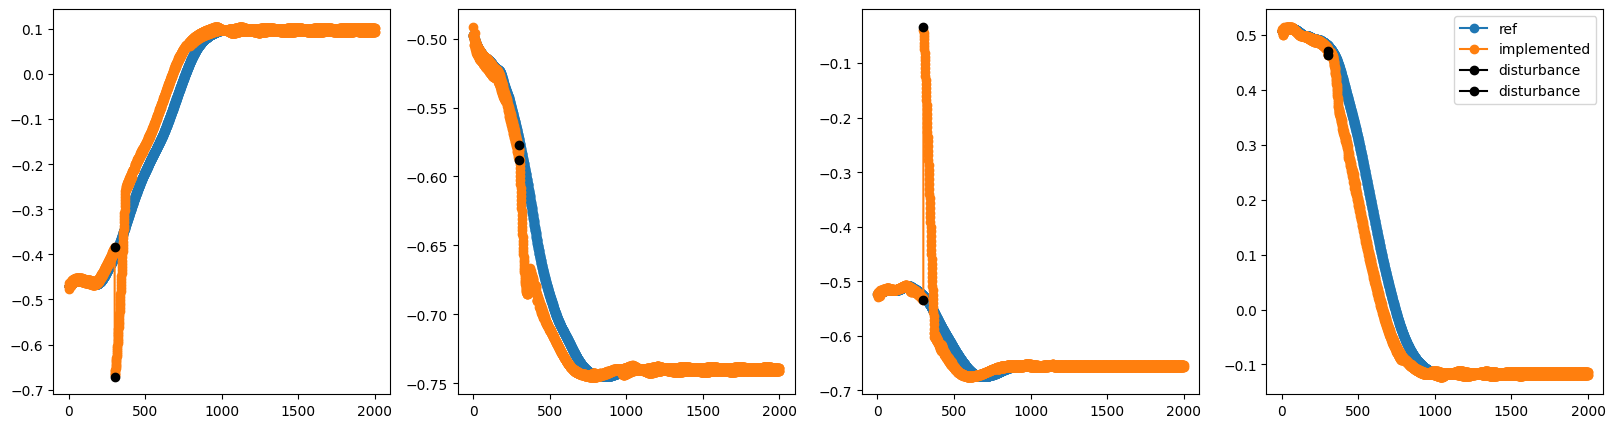

In [ ]:
# Quaternion trajectory
fig, axs = plt.subplots(1,4, figsize=(20,5))
for i in range(4):
  axs[i].plot(xref[:, 3+i], label='ref', marker='o')
  axs[i].plot(xall[:,3+i], label='implemented', marker='o')
  axs[i].plot(dist_ind, x_dist_p[3+i], label='disturbance', marker='o', color='black')
  axs[i].plot(dist_ind, x_dist[3+i], label='disturbance', marker='o', color='black')
plt.legend()

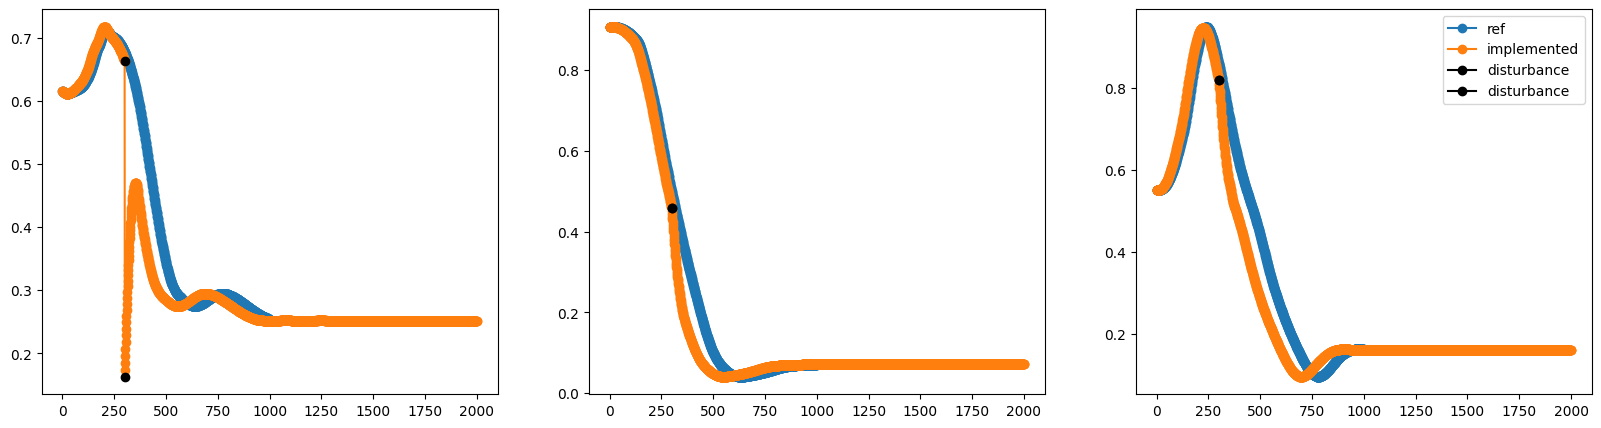

In [ ]:
# Position trajectory
fig, axs = plt.subplots(1,3, figsize=(20,5))
for i in range(3):
  axs[i].plot(xref[:, i], label='ref', marker='o')
  axs[i].plot(xall[:,i], label='implemented', marker='o')
  axs[i].plot(dist_ind, x_dist_p[i], label='disturbance', marker='o', color='black')
  axs[i].plot(dist_ind, x_dist[i], label='disturbance', marker='o', color='black')
plt.legend()

In [ ]:
skip = 5

def plot_rot_matr(xref, xall, dist_ind):
  rotation_matrices_ref = quat_to_rot_mat(xref[::skip, 3:])
  rotation_matrices_imp = quat_to_rot_mat(xall[::skip, 3:])

  phi, theta = np.mgrid[0.0:2.0*np.pi:100j, 0.0:np.pi:50j]
  x = np.sin(theta) * np.cos(phi)
  y = np.sin(theta) * np.sin(phi)
  z = np.cos(theta)

  # Plot on the SO(3) manifold
  figs_rot_dist = go.Figure()
  # for i in range(3):
  figs_rot_dist.add_trace(go.Surface(x=x, y=y, z=z, colorscale='Blues', opacity=0.5, showlegend=False, showscale=False))

  color_all = ['#AB63FA', '#FFA15A', '#FF6692']
  color_all_imp = ['#2CA02C', '#D62728', '#8C564B']
  name_all = ['Ref 1', 'Ref 2', 'Ref 3']
  name_all_imp = ['Implemented 1', 'Implemented 2', 'Implemented 3']

  arrows=[]
  for i in range(3):
    x_d_p, y_d_p, z_d_p=rotation_matrices_imp[int(dist_ind/skip), :, i].T
    x_d, y_d, z_d=rotation_matrices_imp[int(dist_ind/skip)+1, :, i].T
    if i>0:
      figs_rot_dist.add_trace(go.Cone(x=[x_d], y=[y_d], z=[z_d],
                                    u=[x_d - x_d_p], v=[y_d - y_d_p], w=[z_d - z_d_p],
                                    colorscale='greys',  showlegend=False, showscale=False))
    else:
      figs_rot_dist.add_trace(go.Cone(x=[x_d], y=[y_d], z=[z_d],
                                    u=[x_d - x_d_p], v=[y_d - y_d_p], w=[z_d - z_d_p],
                                    colorscale='greys',  name='Disturbance', showscale=False))

  for i in range(3):
    figs_rot_dist.add_trace(go.Scatter3d(x=rotation_matrices_ref[:, 0, i], y=rotation_matrices_ref[:, 1, i], z=rotation_matrices_ref[:, 2, i],
                                      mode='lines', line=dict(width=10, color=color_all[i]), name=name_all[i]))
    figs_rot_dist.add_trace(go.Scatter3d(x=rotation_matrices_imp[:int(dist_ind/skip), 0, i], y=rotation_matrices_imp[:int(dist_ind/skip), 1, i], z=rotation_matrices_imp[:int(dist_ind/skip), 2, i],
                                      mode='lines', line=dict(width=10, color=color_all_imp[i]), name=name_all_imp[i]))

  for i in range(3):
    x_s, y_s, z_s = rotation_matrices_ref[0, :, i].T
    x_e, y_e, z_e = rotation_matrices_ref[-1, :, i].T
    if i == 2:
      figs_rot_dist.add_trace(go.Scatter3d(x=[x_s], y=[y_s], z=[z_s], mode='markers', line=dict(color='red', width=5),  name='Start'))
      figs_rot_dist.add_trace(go.Scatter3d(x=[x_e], y=[y_e], z=[z_e], mode='markers', line=dict(color='blue', width=5),  name='End'))
    else:
      figs_rot_dist.add_trace(go.Scatter3d(x=[x_s], y=[y_s], z=[z_s], mode='markers', line=dict(color='red', width=5),  name='Start', showlegend=False))
      figs_rot_dist.add_trace(go.Scatter3d(x=[x_e], y=[y_e], z=[z_e], mode='markers', line=dict(color='blue', width=5),  name='End', showlegend=False))

  for i in range(3):
    figs_rot_dist.add_trace(go.Scatter3d(x=rotation_matrices_imp[int(dist_ind/skip)+1:, 0, i], y=rotation_matrices_imp[int(dist_ind/skip)+1:, 1, i],
                                        z=rotation_matrices_imp[int(dist_ind/skip)+1:, 2, i], mode='lines', line=dict(width=10, color=color_all_pred[i]), name=name_all_pred[i], showlegend=False))
    if i== 0:
      figs_rot_dist.add_trace(go.Scatter3d(x=rotation_matrices_imp[int(dist_ind/skip):int(dist_ind/skip)+2, 0, i],
                                          y=rotation_matrices_imp[int(dist_ind/skip):int(dist_ind/skip)+2:, 1, i],
                                          z=rotation_matrices_imp[int(dist_ind/skip):int(dist_ind/skip)+2, 2, i],
                                          mode='lines', line=dict(width=10, color='black'), name='Disturbance'))
    else:
        figs_rot_dist.add_trace(go.Scatter3d(x=rotation_matrices_imp[int(dist_ind/skip):int(dist_ind/skip)+2, 0, i],
                                        y=rotation_matrices_imp[int(dist_ind/skip):int(dist_ind/skip)+2, 1, i],
                                        z=rotation_matrices_imp[int(dist_ind/skip):int(dist_ind/skip)+2, 2, i],
                                        mode='lines', line=dict(width=10, color='black'), name='Disturbance', showlegend=False))

  figs_rot_dist.update_layout(
      font=dict(
          family="Times New Roman",
          size=18
      ),
      legend= {'itemsizing': 'constant'},
      scene=dict(aspectmode="cube")
  )

  figs_rot_dist.show()

  return figs_rot

figs_rot_dist = plot_rot_matr(xref, xall, dist_ind)

# Load predicted trajectories

In [ ]:
## load training data and predicted trajectories
predicted_trajs_dir = 'clfd_bottle2shelf_traj_NODE.npy'
with open(predicted_trajs_dir, 'rb') as f:
  traj_data_process=jnp.load(f)
  data_transformed_sphere_all = jnp.load(f)
  ys_pred_act_all = jnp.load(f)
  traj_transformed_sphere_all = jnp.load(f)

In [ ]:
phi, theta = np.mgrid[0.0:2.0*np.pi:100j, 0.0:np.pi:50j]
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

fig1 = go.Figure(data=[go.Surface(x=x, y=y, z=z, colorscale='Blues', opacity=0.5, showlegend=False, showscale=False)])

ind_demo = 6
fig1.add_trace(go.Scatter3d(x=data_transformed_sphere_all[ind_demo, :, 0], y=data_transformed_sphere_all[ind_demo, :, 1], z=data_transformed_sphere_all[ind_demo, :, 2], mode='lines',
                          line=dict(color='grey', width=20),  name='Training Data'))

fig1.add_trace(go.Scatter3d(x=traj_transformed_sphere_all[ind_demo, :, 0], y=traj_transformed_sphere_all[ind_demo, :, 1], z=traj_transformed_sphere_all[ind_demo, :, 2], mode='lines',
                           line=dict(color='green', width=20), name='Predicted'))
fig1.add_trace(go.Scatter3d(x=data_transformed_sphere_all[ind_demo, :1, 0], y=data_transformed_sphere_all[ind_demo, :1, 1], z=data_transformed_sphere_all[ind_demo, 0:1, 2], mode='markers',
                          line=dict(color='red', width=5),  name='Start'))
fig1.add_trace(go.Scatter3d(x=data_transformed_sphere_all[ind_demo, -2:, 0], y=data_transformed_sphere_all[ind_demo, -2:, 1], z=data_transformed_sphere_all[ind_demo, -2:, 2], mode='markers',
                          line=dict(color='blue', width=5),  name='End'))
fig1.update_layout(
    font=dict(
        family="Times New Roman",
        size=18
    ),
    legend= {'itemsizing': 'constant'}
)

fig1.show()

In [ ]:
fig2 = go.Figure()
ind_demo = 6
fig2.add_trace(go.Scatter3d(x=traj_data_process[ind_demo, :, 0], y=traj_data_process[ind_demo, :, 1], z=traj_data_process[ind_demo, :, 2], mode='lines',
                          line=dict(color='grey', width=20), name='Training Data'))
fig2.add_trace(go.Scatter3d(x=ys_pred_act_all[ind_demo, :, 0], y=ys_pred_act_all[ind_demo, :, 1], z=ys_pred_act_all[ind_demo, :, 2], mode='lines',
                           line=dict(color='green', width=20), name='Predicted'))
fig2.add_trace(go.Scatter3d(x=traj_data_process[ind_demo, :1, 0], y=traj_data_process[ind_demo, :1, 1], z=traj_data_process[ind_demo, :1, 2], mode='markers',
                          line=dict(color='red', width=5), name='Start'))
fig2.add_trace(go.Scatter3d(x=traj_data_process[ind_demo, -2:-1, 0], y=traj_data_process[ind_demo, -2:-1, 1], z=traj_data_process[ind_demo, -2:-1, 2], mode='markers',
                          line=dict(color='blue', width=5), name='End'))


fig2.update_layout(
    font=dict(
        family="Times New Roman",
        size=18
    ),
    legend= {'itemsizing': 'constant'}
)

fig2.show()

In [ ]:
## saving training data and predicted trajectories
predicted_trajs_dir = 'clfd_bottle2shelf_traj_NODE.npy'
with open(predicted_trajs_dir, 'wb') as f:
  jnp.save(f, traj_data_process)
  jnp.save(f, data_transformed_sphere_all)
  jnp.save(f, ys_pred_act_all)
  jnp.save(f, traj_transformed_sphere_all)

In [ ]:
# Checking if predicted quaternion trajectory stays on the manifold
jnp.max(jnp.linalg.norm(ys_pred[:,3:], axis=-1))

Array(1.0000788, dtype=float32)

# Plotly export for webpage

In [ ]:
!pip install chart-studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.7 MB/s eta 0:00:00


In [ ]:
import chart_studio
username='<your plotly chart username>'
api_key='<your plotly user api key>'
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.express as px

In [ ]:
py.plot(fig, filename="clfd_pouring_pos", auto_open = True)
# py.plot(fig2_dist, filename="clfd_bottle2shelf_pos_dist", auto_open = True)

'https://plotly.com/~nawazfarhad/20/'

# Angular velocity

In [ ]:
# Angular velocity
f = lambda z: model.func_rot.mlp(z)
linear_angular_vel = jax.vmap(f, in_axes = 0)(ys[ind_demo]) # [x_dot, angular_velocity]

fig1 = go.Figure()

fig1.add_trace(go.Scatter3d(x=linear_angular_vel[:, 3], y=linear_angular_vel[:, 4], z=linear_angular_vel[:, 5], mode='lines',
                           line=dict(color='green', width=4)))
fig1.write_html("angular_velocity.html")
fig1.show()

## Verifying if the angular velocity predicted by our model is proper

Comparing $\dot{q}$ predicted directly from the model with the $\dot{q}$ computed using the angular velocity predicted by our model.

In [ ]:
def quat_mult(q1, q2):
  q1_s = q1[0]
  q2_s = q2[0]
  q1_v = q1[1:].reshape((-1,1))
  q2_v = q2[1:].reshape((-1,1))
  scalar = q1_s*q2_s - q1_v.T @ q2_v
  skew = jnp.array([[0, -q1[3], q1[2]],
                    [q1[3], 0, -q1[1]],
                    [-q1[2], q1[1], 0]])
  vector = q1_s*q2_v + q2_s*q1_v + skew @ q2_v
  q_result = jnp.concatenate((scalar, vector), axis=0).flatten()
  return q_result

def Log_map(q):
  q_s = q[0]
  vector = q[1:]
  vector_norm = jnp.linalg.norm(vector)

  # Round off scalar_quat_prod to take care of errors due to numerical errors
  q_s = jnp.round(q_s, 4)

  log_quat = jnp.where(vector_norm > 0, jnp.arccos(q_s)*(vector/vector_norm), jnp.array([0.0,0.0,0.0]))

  return log_quat

def quat_err(q1, q2):
  q2_c = q2.at[1:].set(-q2[1:])
  delta_q = quat_mult(q1, q2_c)
  return Log_map(delta_q)

In [ ]:
# quaternion error
ind_demo = 0
quat_err_all = jax.vmap(quat_err, in_axes=(0, 0))(ys_pred[:, 3:], traj_data_process[ind_demo, :, 3:])
jnp.mean(quat_err_all**2)

Array(0.10586332, dtype=float32)

In [ ]:
# position error
jnp.mean((ys_pred[:, 3:] - traj_data_process[ind_demo, :, 3:])**2)

Array(0.07495818, dtype=float32)

In [ ]:
f2 = lambda z: model.func_rot(_, z, _)
y_dot_pred = jax.vmap(f2, in_axes = 0)(ys[ind_demo]) # y_dot = [x_dot, q_dot]

In [ ]:
# 'result_vect_field' = [x_dot, q_dot_w]. Here, q_dot_w is computed as q_dot_w = 0.5*[0, w^T]^T * q,
# where w = angular_velocity from the mlp model and q is the quaternion measurements from the demonstrations.
ang_vel = linear_angular_vel[:, 3:]

quat = traj_data_process[ind_demo, :, 3:]

ang_vel_quat = jnp.concatenate((jnp.zeros((quat.shape[0], 1)), ang_vel), axis=-1)

quat_vect_field = 0.5*jax.vmap(quat_mult, in_axes=(0, 0))(ang_vel_quat, quat)

result_vect_field = jnp.concatenate((linear_angular_vel[:, :3], quat_vect_field), axis=-1)

In [ ]:
# Checking if q_dot_w = q_dot
jnp.max(jnp.linalg.norm(y_dot_pred[:, 3:] - result_vect_field[:, 3:] ,axis=-1))

Array(1.1200679e-07, dtype=float32)